<a href="https://colab.research.google.com/github/castlechoi/studyingDL/blob/main/dacon/calories_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [45]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [46]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

## Preprocessing

In [47]:
le = LabelEncoder()
train_df['Weight_Status'] = le.fit_transform(train_df['Weight_Status'])
le = LabelEncoder()
train_df['Gender'] = le.fit_transform(train_df['Gender'])
le = LabelEncoder()
test_df['Weight_Status'] = le.fit_transform(test_df['Weight_Status'])
le = LabelEncoder()
test_df['Gender'] = le.fit_transform(test_df['Gender'])

## Visualization

<ipython-input-5-6c3475b36d78>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_df.corr(), annot = True)


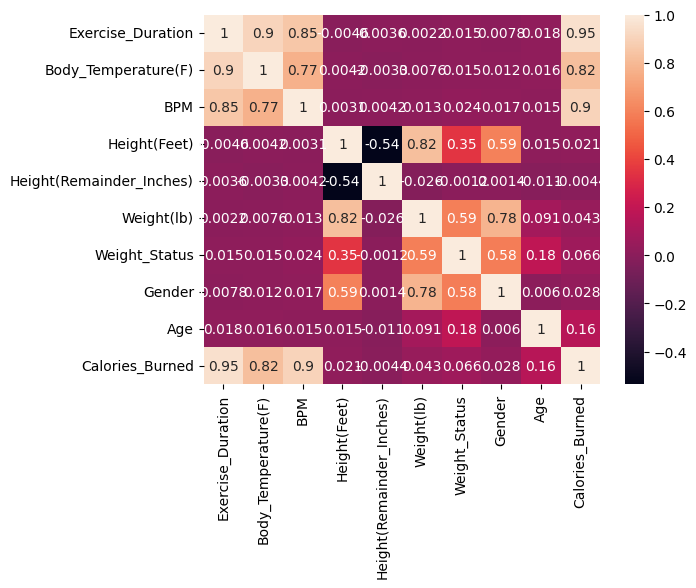

In [5]:

sns.heatmap(train_df.corr(), annot = True)
plt.show()

## Feature Engineering

In [48]:
train_df['Height_Full'] = train_df['Height(Feet)'] * 12 + train_df['Height(Remainder_Inches)']
test_df['Height_Full'] = test_df['Height(Feet)'] * 12 + test_df['Height(Remainder_Inches)']

train_df.drop(columns = ['Height(Feet)', 'Height(Remainder_Inches)','ID'], inplace = True)
test_df.drop(columns = ['Height(Feet)', 'Height(Remainder_Inches)','ID'], inplace = True)

In [49]:
gender_mean = train_df.groupby('Gender').mean()
gender_mean.drop(columns = gender_mean.columns.drop('Calories_Burned'), inplace = True)
gender_mean.rename(columns = {'Calories_Burned':'Gender_mean'}, inplace = True)

weight_mean = train_df.groupby('Weight_Status').mean()
weight_mean.drop(columns = weight_mean.columns.drop('Calories_Burned'), inplace = True)
weight_mean.rename(columns = {'Calories_Burned':'Weight_mean'}, inplace = True)

train_df = pd.merge(train_df, gender_mean, how = 'left',on = ['Gender'])
train_df = pd.merge(train_df, weight_mean, how = 'left',on = ['Weight_Status'])

test_df = pd.merge(test_df, gender_mean, how = 'left',on = ['Gender'])
test_df = pd.merge(test_df, weight_mean, how = 'left',on = ['Weight_Status'])

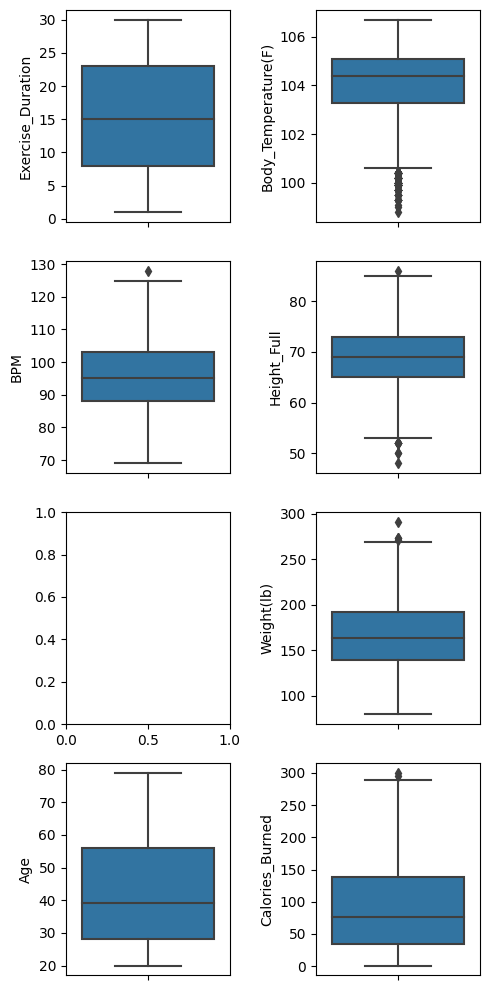

In [19]:
fig, axes = plt.subplots(4,2, figsize = (5,10))

sns.boxplot(y = train_df['Exercise_Duration'], ax = axes[0][0])
sns.boxplot(y = train_df['Body_Temperature(F)'], ax = axes[0][1])

sns.boxplot(y = train_df['BPM'], ax = axes[1][0])
sns.boxplot(y = train_df['Height_Full'], ax = axes[1][1])

sns.boxplot(y = train_df['Weight(lb)'], ax = axes[2][1])

sns.boxplot(y = train_df['Age'], ax = axes[3][0])
sns.boxplot(y = train_df['Calories_Burned'], ax = axes[3][1])

plt.tight_layout()
plt.show()

In [38]:
# body temperature은 log transformation
# bpm, height_full, weight(lb) 이상치 확인

""" IQR 처리 """
outlier_column = ['BPM','Height_Full','Weight(lb)','Calories_Burned']
for i in outlier_column:
  Q1 = train_df[i].quantile(0.25)
  Q3 = train_df[i].quantile(0.75)

  IQR = Q3 - Q1
  MIN = Q1 - 1.5 * IQR
  MAX = Q3 + 1.5 * IQR
  target = train_df[(train_df[i] < MIN) | (train_df[i] > MAX)]
  train_df.drop(target.index, inplace = True)
  print(f'{len(target.index)} data is outlier')
print(f'Delete the data...')

1 data is outlier
11 data is outlier
3 data is outlier
2 data is outlier
Delete the data...


In [39]:
mm_list =[]

for idx,i in enumerate(train_df.columns):
  if i == 'Calories_Burned' :
    continue
  mm = MinMaxScaler()
  fitted = mm.fit(train_df[i].values.reshape(-1,1))
  result = mm.transform(train_df[i].values.reshape(-1,1))
  train_df[i] = result.reshape(-1)
  mm_list.append(mm)
for idx, i in enumerate(test_df.columns):
  result = mm_list[idx].transform(test_df[i].values.reshape(-1,1))
  test_df[i] = result.reshape(-1)

In [23]:
!pip install autogluon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.3/218.3 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.2/292.2 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/108.7 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━

In [50]:
from autogluon.tabular import TabularPredictor
predictor = TabularPredictor(label = 'Calories_Burned', eval_metric = 'rmse',problem_type = 'regression' ) . fit(train_data = train_df)

No path specified. Models will be saved in: "AutogluonModels/ag-20230415_063340/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230415_063340/"
AutoGluon Version:  0.7.0
Python Version:     3.9.16
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Dec 10 16:00:40 UTC 2022
Train Data Rows:    7500
Train Data Columns: 10
Label Column: Calories_Burned
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    10841.27 MB
	Train Data (Original)  Memory Usage: 0.6 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	

[1000]	valid_set's rmse: 1.72357
[2000]	valid_set's rmse: 1.50226
[3000]	valid_set's rmse: 1.42506
[4000]	valid_set's rmse: 1.39627
[5000]	valid_set's rmse: 1.37625
[6000]	valid_set's rmse: 1.36359
[7000]	valid_set's rmse: 1.35469
[8000]	valid_set's rmse: 1.34826
[9000]	valid_set's rmse: 1.33969
[10000]	valid_set's rmse: 1.33596


	-1.3356	 = Validation score   (-root_mean_squared_error)
	12.11s	 = Training   runtime
	0.94s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's rmse: 1.48973
[2000]	valid_set's rmse: 1.41379
[3000]	valid_set's rmse: 1.40695


	-1.4048	 = Validation score   (-root_mean_squared_error)
	3.19s	 = Training   runtime
	0.28s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-3.3419	 = Validation score   (-root_mean_squared_error)
	7.84s	 = Training   runtime
	0.17s	 = Validation runtime
Fitting model: CatBoost ...
	-0.5728	 = Validation score   (-root_mean_squared_error)
	86.46s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-2.9413	 = Validation score   (-root_mean_squared_error)
	2.49s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-1.3253	 = Validation score   (-root_mean_squared_error)
	8.31s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: XGBoost ...
	-1.7003	 = Validation score   (-root_mean_squared_error)
	11.02s	 = Training   runtime
	0.52s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-2.835	 = Validation score   (-root_mean_squared_error)
	12.82s	 = Training   runtime
	0.01s	 = Validation run

[1000]	valid_set's rmse: 1.88782
[2000]	valid_set's rmse: 1.87527
[3000]	valid_set's rmse: 1.87182
[4000]	valid_set's rmse: 1.87111
[5000]	valid_set's rmse: 1.87098
[6000]	valid_set's rmse: 1.87084
[7000]	valid_set's rmse: 1.87076
[8000]	valid_set's rmse: 1.87073
[9000]	valid_set's rmse: 1.87072
[10000]	valid_set's rmse: 1.87072


	-1.8707	 = Validation score   (-root_mean_squared_error)
	24.71s	 = Training   runtime
	1.47s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-0.5387	 = Validation score   (-root_mean_squared_error)
	0.49s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 182.74s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20230415_063340/")


In [ ]:
# male_cnt = 0 
# female_cnt = 0
# test_df['Calories_Buned'] = [0.1 for i in range(len(test_df))]
# for idx in range(len(test_df)):
#   if test_df.loc[idx,'Gender'] == 0.0:
#     test_df.loc[idx,'Calories_Burned'] = male_pred.values[male_cnt]
#     male_cnt +=1
#   else:
#     test_df.loc[idx,'Calories_Burned'] = female_pred.values[female_cnt]
#     female_cnt += 1


In [51]:
submission = pd.read_csv('./sample_submission.csv')
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               7500 non-null   object
 1   Calories_Burned  7500 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 117.3+ KB


In [52]:
y_pred = predictor.predict(test_df)

In [53]:
submission['Calories_Burned'] = y_pred
submission.to_csv('./submission.csv', index = False)
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               7500 non-null   object 
 1   Calories_Burned  7500 non-null   float32
dtypes: float32(1), object(1)
memory usage: 88.0+ KB
